In [1]:
# Cargar Librerias Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Carga de datos

In [2]:
# Cargar lista de insumos
dir = 'raw_data/'
file = 'files_list.csv'

file_df = pd.read_csv(dir + file, index_col='ind')

#Separar códigos bursátiles
pattern = r'\((.*?)\)'

file_df['stock'] = file_df['name'].str.extract(pattern)
file_df['name'] = file_df['name'].str.replace(pattern, '')

# Seleccionar el top de empresas a usar (siempre cargar negativos y 0)
top_n = 10

file_df = file_df[file_df.index < top_n + 1]
file_df

C:\Users\Carlos\AppData\Local\Temp\ipykernel_22240\287536555.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  file_df['name'] = file_df['name'].str.replace(pattern, '')


,name,stock
ind,,
-2,FEDFUNDS,FEDFUNDS
-1,UNRATE,UNRATE
0,NASDAQ 100,^NDX
1,Apple Inc.,AAPL
2,Microsoft Corporation,MSFT
3,"Amazon.com, Inc.",AMZN
4,NVIDIA Corporation,NVDA
5,"Meta Platforms, Inc.",META
6,Broadcom Inc.,AVGO


In [3]:
# Cargar archivos en dataframe y gardarlos en diccionario
stocks_dict = {}

for f in file_df['stock']:
    file = f + '.csv'
    df_name = f + '_DF'
    df = pd.read_csv(dir + file)
    stocks_dict[df_name] = df

stocks_dict.keys()

dict_keys(['FEDFUNDS_DF', 'UNRATE_DF', '^NDX_DF', 'AAPL_DF', 'MSFT_DF', 'AMZN_DF', 'NVDA_DF', 'META_DF', 'AVGO_DF', 'TSLA_DF', 'GOOG_DF', 'GOOGL_DF', 'ADBE_DF'])

# Preprocesado de datos

In [4]:
# Parsear formato de fechas para FEDFUNDS y UNRATE
macros = ['FEDFUNDS_DF', 'UNRATE_DF']
stocks = [key for key in stocks_dict.keys() if key not in macros]

for i in macros:
    stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0], format='%d/%m/%Y')
    stocks_dict[i].iloc[:,0] = stocks_dict[i].iloc[:,0].dt.strftime('%Y-%m-%d')

    # Cambiar nombre de columna a Date
    stocks_dict[i].rename(columns= {'DATE' : 'Date'}, inplace= True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_22240\857105010.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0], format='%d/%m/%Y')
C:\Users\Carlos\AppData\Local\Temp\ipykernel_22240\857105010.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  stocks_dict[i].iloc[:,0] = stocks_dict[i].iloc[:,0].dt.strftime('%Y-%m-%d')
C:\Users\Carlos\AppData\Local\Temp\ipykernel_22240\857105010.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the

In [5]:
# Visualización de los dataframe
stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


In [6]:
# Seleccionar variables que nos interesan y eliminar las demas de los DF
variables = ['Date', 'FEDFUNDS', 'UNRATE', 'Open', 'Close', 'Volume']

for df in stocks_dict.keys():
    for col in stocks_dict[df].columns:
        if col not in variables:
            stocks_dict[df].drop(col, axis= 1, inplace= True)

stocks_dict['AAPL_DF'].columns

Index(['Date', 'Open', 'Close', 'Volume'], dtype='object')

In [7]:
# Definimos fechas inicio y fin, eliminaremos todo lo que no esté en este rango
start_date= '2012-06-01'           # Usamos esta fecha porque es cuando Meta (la más reciente, entro en cotización)
end_date= '2023-12-31'

for df in stocks_dict.keys():
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] < start_date].index, inplace=True)
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] > end_date].index, inplace=True)

stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
695,2012-06-01,0.16
696,2012-07-01,0.16
697,2012-08-01,0.13
698,2012-09-01,0.14
699,2012-10-01,0.16
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


# Análisis exploratorio de datos (Exploratory Data Analysis)

**El siguiente código tiene como objetivo detectar valores nulos o duplicados en distintos conjuntos de datos.**

In [8]:
# Visualizar información de cada DF y alertar por nulos y duplicados
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    stocks_dict[df].info()

    null_values = stocks_dict[df].isnull().any()
    if null_values.any():
        print("Advertencia: " + df + " contiene nulos!!")

    duplicated_rows = stocks_dict[df].duplicated()
    if duplicated_rows.any():
        print("Advertencia: " + df + " contiene duplicados!!")

    print()
    print()

***** FEDFUNDS_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 695 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      139 non-null    object 
 1   FEDFUNDS  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** UNRATE_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 773 to 911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    139 non-null    object 
 1   UNRATE  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** ^NDX_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 6726 to 9639
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   Close   2914 non-null   float64
 3   Volume  291

Según los resultados obtenidos del código previo, podemos concluir que no hay valores duplicados ni nulos.

**A continuación, presentamos un resumen de las características del conjunto de datos.**

In [9]:
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    print(stocks_dict[df].describe())
    print()
    print()

***** FEDFUNDS_DF *****
         FEDFUNDS
count  139.000000
mean     1.119568
std      1.490514
min      0.050000
25%      0.090000
50%      0.360000
75%      1.695000
max      5.330000


***** UNRATE_DF *****
           UNRATE
count  139.000000
mean     5.260432
std      1.895480
min      3.400000
25%      3.800000
50%      4.800000
75%      6.200000
max     14.800000


***** ^NDX_DF *****
               Open         Close        Volume
count   2914.000000   2914.000000  2.914000e+03
mean    7727.255158   7729.470973  2.923642e+09
std     4202.526633   4203.448103  1.517643e+09
min     2458.969971   2458.830078  2.441200e+08
25%     4297.375000   4296.544800  1.817850e+09
50%     6636.185059   6643.979980  2.141175e+09
75%    11633.947266  11675.142822  4.250430e+09
max    16963.519531  16906.800781  1.162119e+10


***** AAPL_DF *****
              Open        Close        Volume
count  2914.000000  2914.000000  2.914000e+03
mean     69.767093    69.819398  1.776664e+08
std      56.02

**Ahora se están graficando las variables con el objetivo de identificar posibles valores atípicos.**

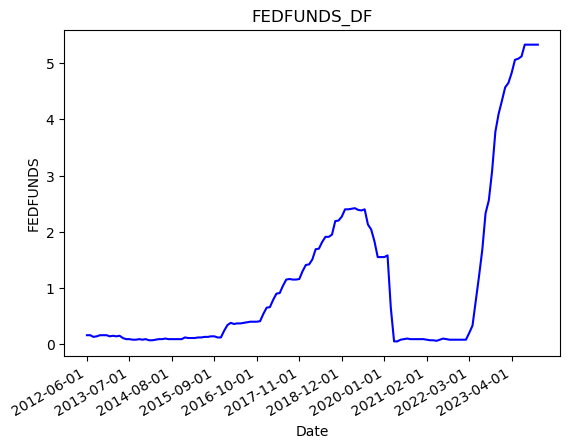

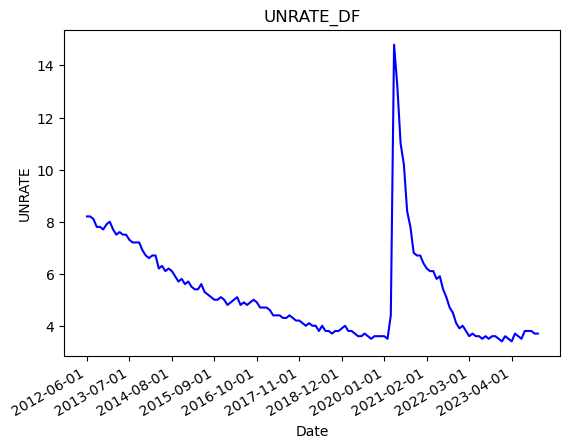

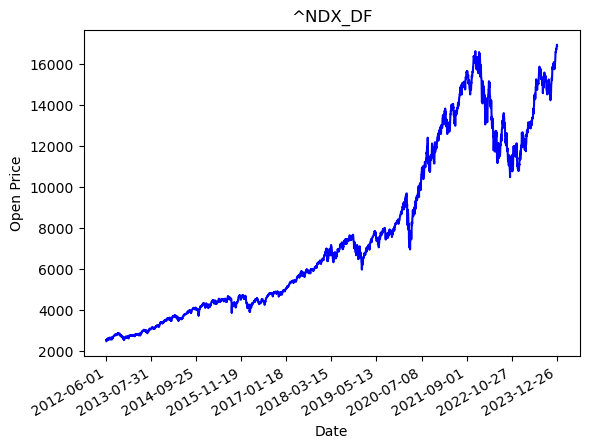

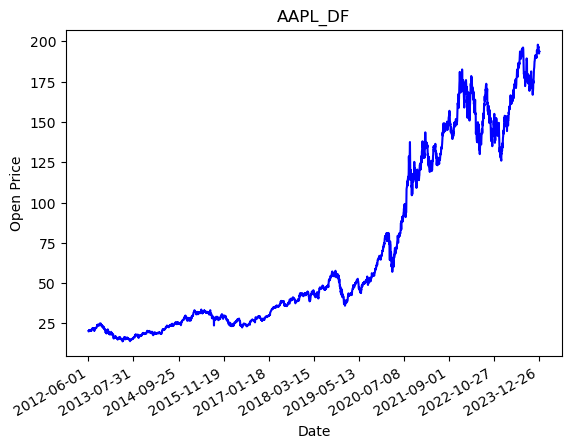

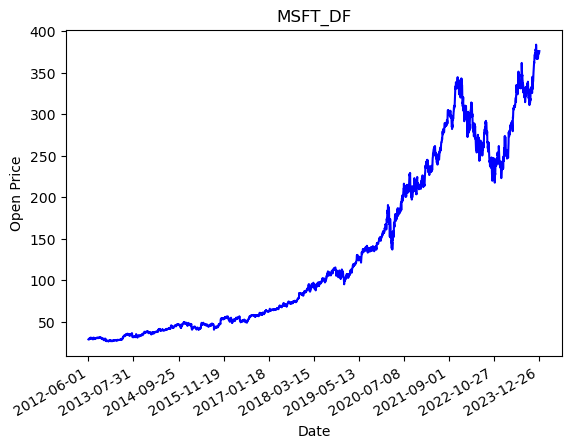

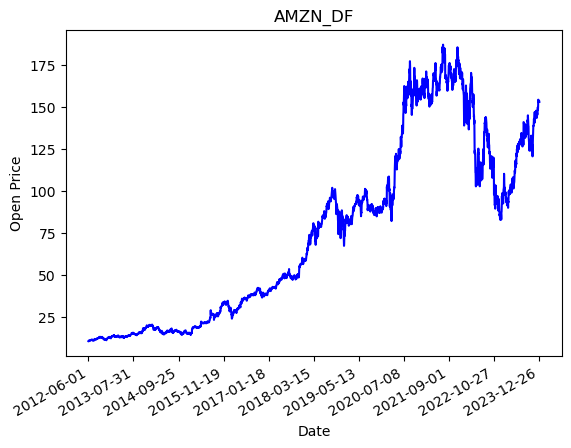

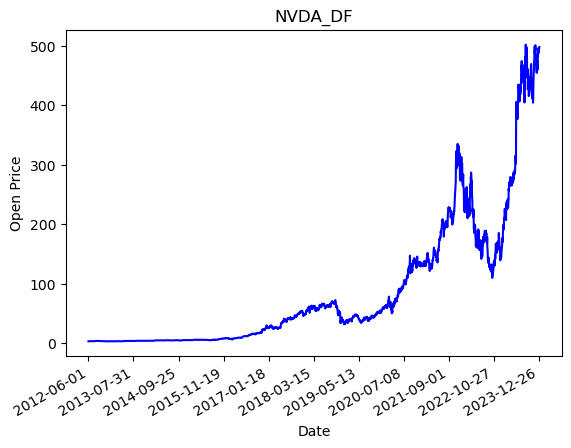

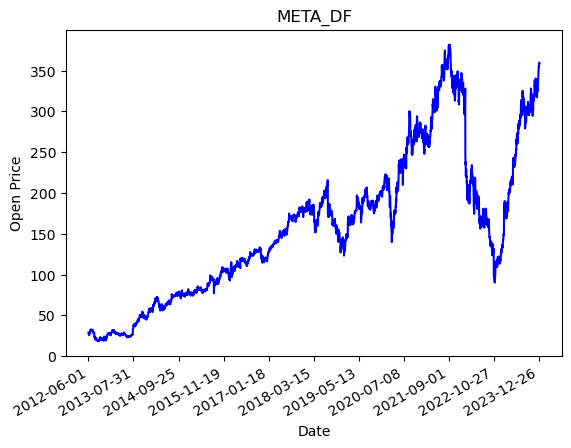

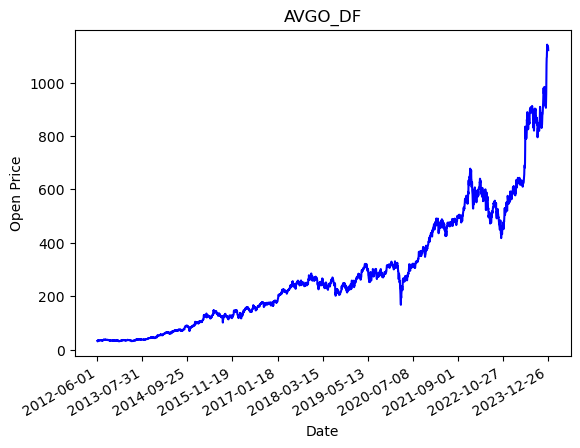

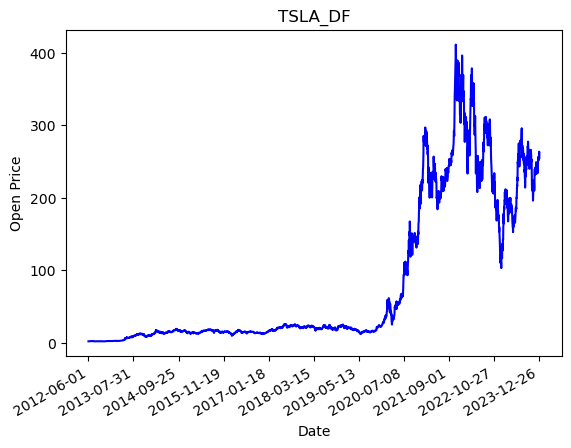

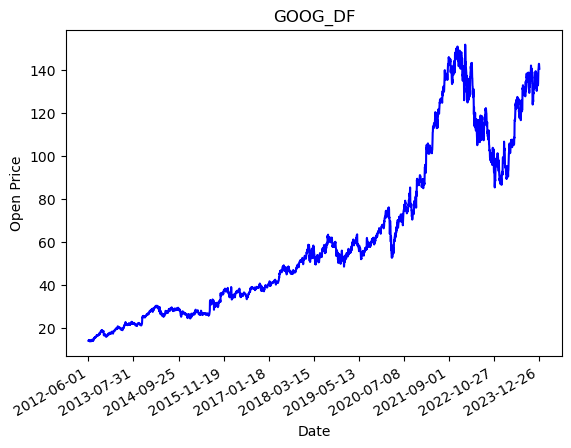

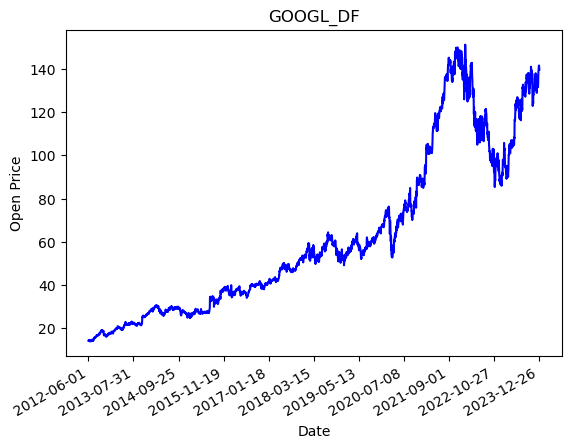

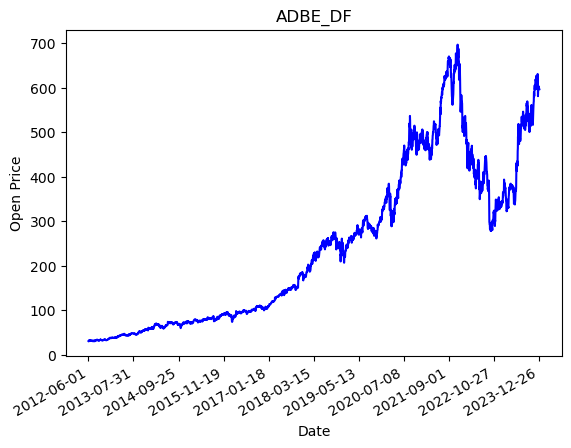

In [10]:
# Graficaremos cada variable
num_ticks = 10

for df in stocks_dict.keys():
    if df in macros:
        fig, ax = plt.subplots()

        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], linestyle= '-', color='b')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1])

    if df in stocks:
        fig, ax = plt.subplots()

        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], label= 'Open Price', linestyle= '-', color='b')
        #ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,2], label= 'Close Price', linestyle= '--', color='r')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1] + ' Price')

plt.show()

Las gráficas anteriores indican que no existen valores atípicos en la variable seleccionada.

**Análisis de cardinalidad.**

Si buscamos determinar la cardinalidad de las variables, podemos afirmar que no hay variables categóricas para analizar. Sin embargo, incluso al intentar analizar la cardinalidad de las variables no categóricas, podemos utilizar las gráficas anteriores para observar que varía de manera diferente en cada empresa, pero en general tiende a ser alta cuando consideramos un plazo de tiempo también extenso.

**Tendencias temporales**

Con base en las gráficas anteriores, también es posible identificar tendencias temporales, las cuales son comunes en este tipo de variables a lo largo del tiempo. Se observa que prácticamente todas las empresas muestran tendencias temporales, como el ejemplo de Amazon, donde se aprecia un crecimiento significativo durante el 2020 y una estabilidad relativa hasta el 2022.

**A continuación, realizaremos un análisis de distribución para cada variable numérica de los dataframes. Este análisis nos permitirá identificar si las variables tienen una distribución normal o si están sesgadas.**

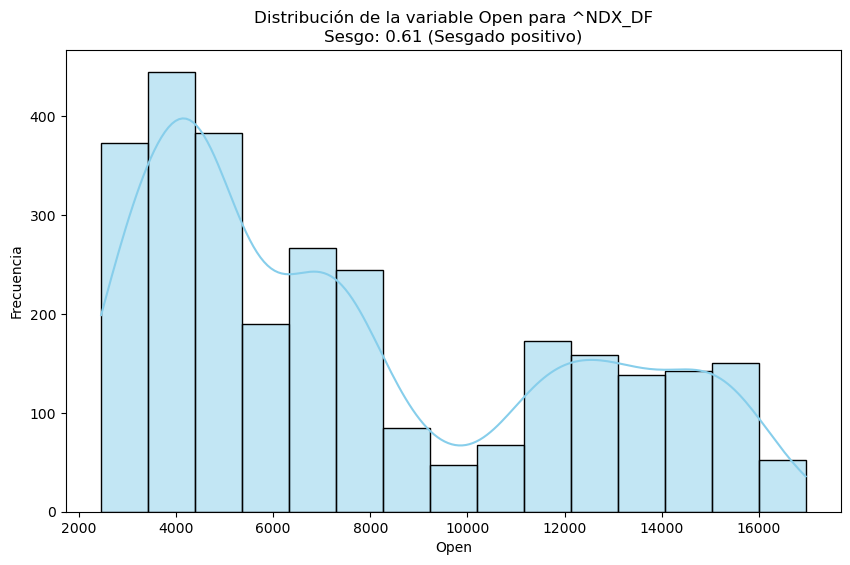

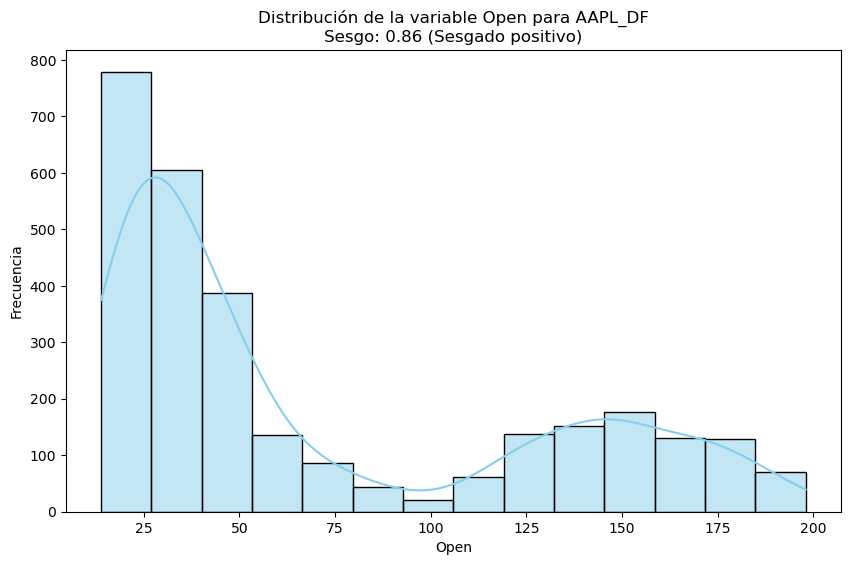

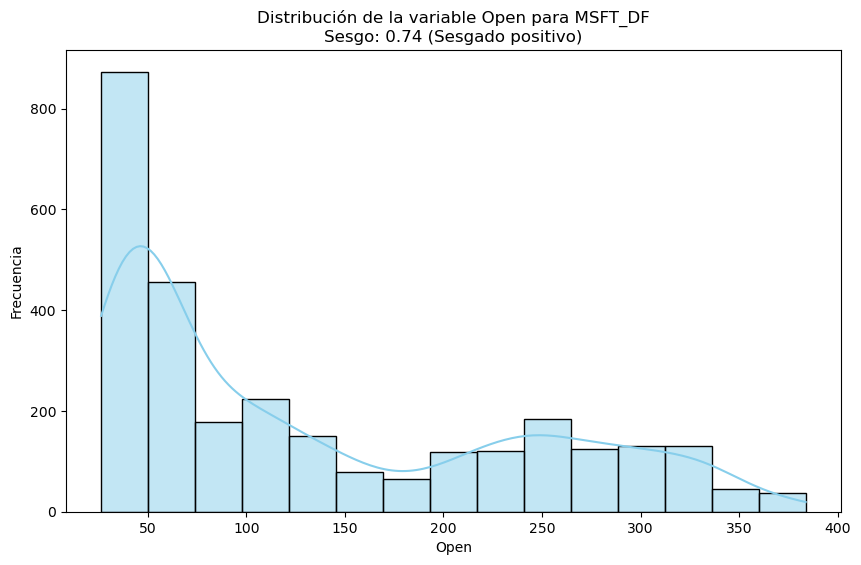

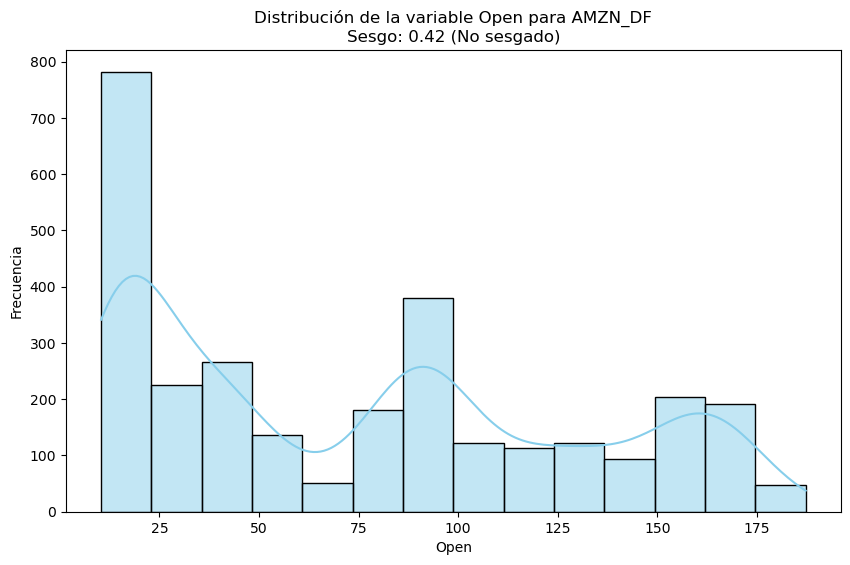

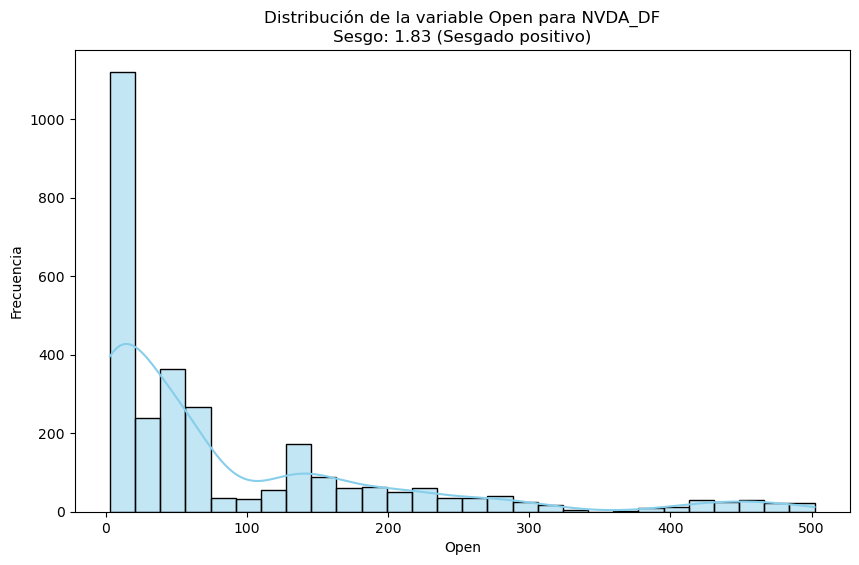

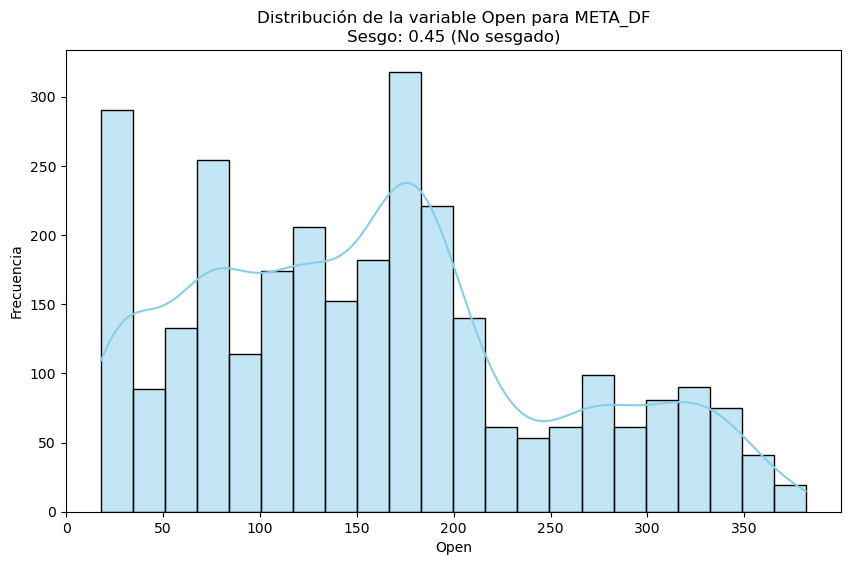

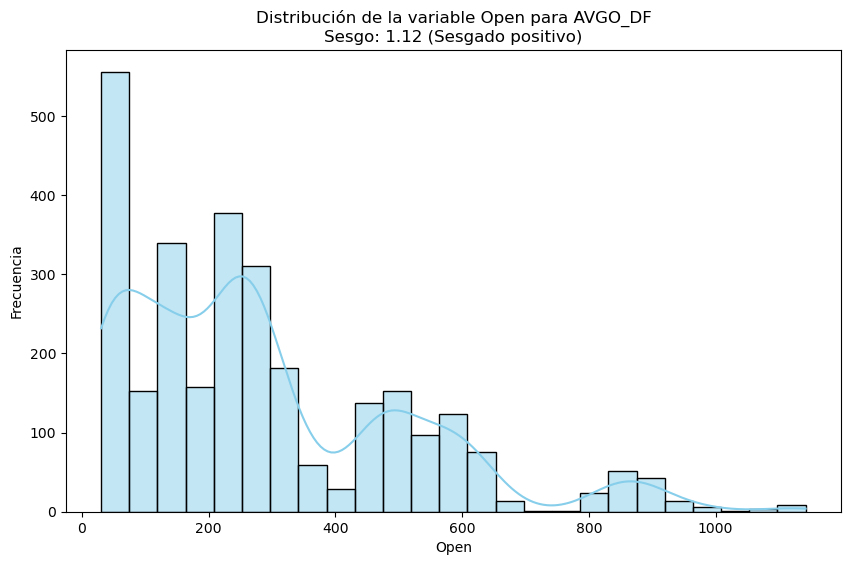

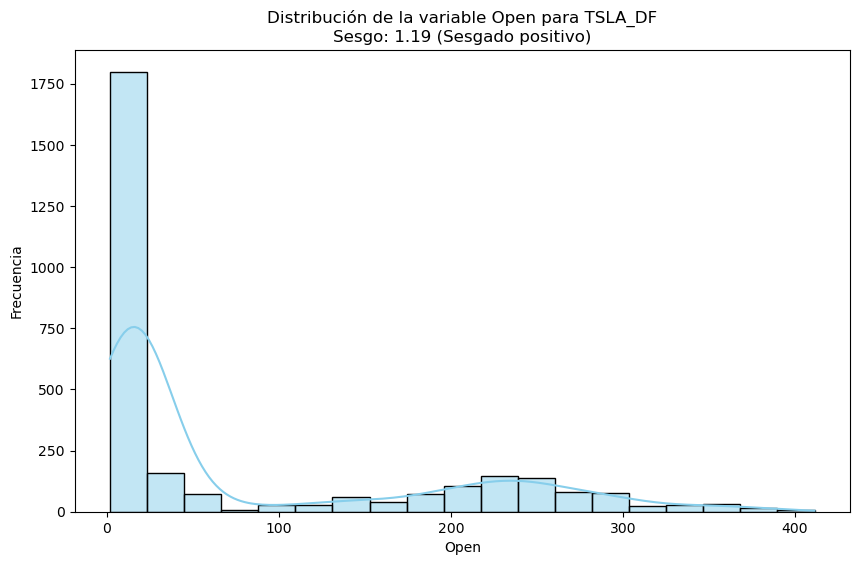

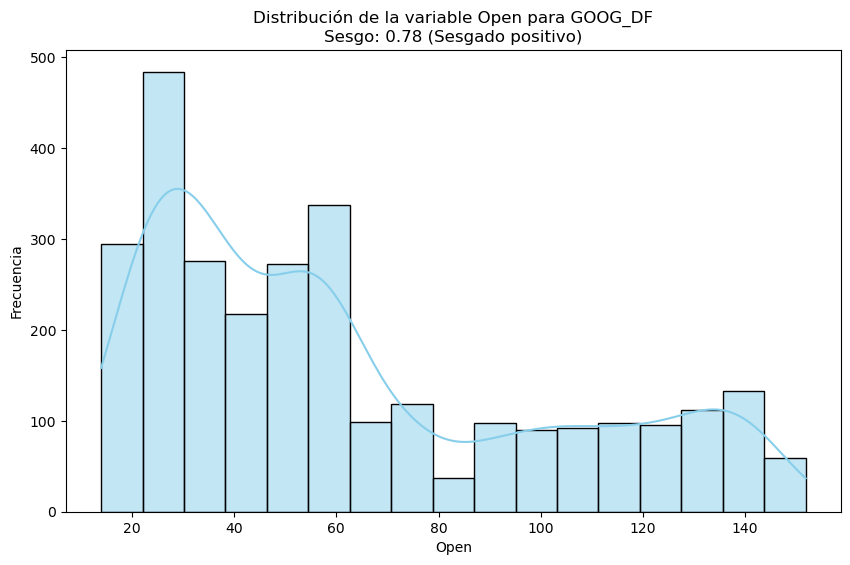

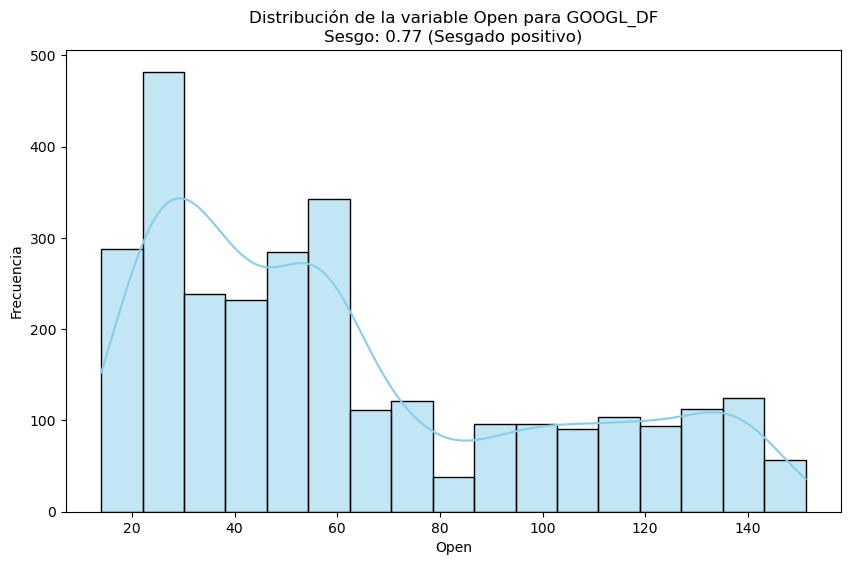

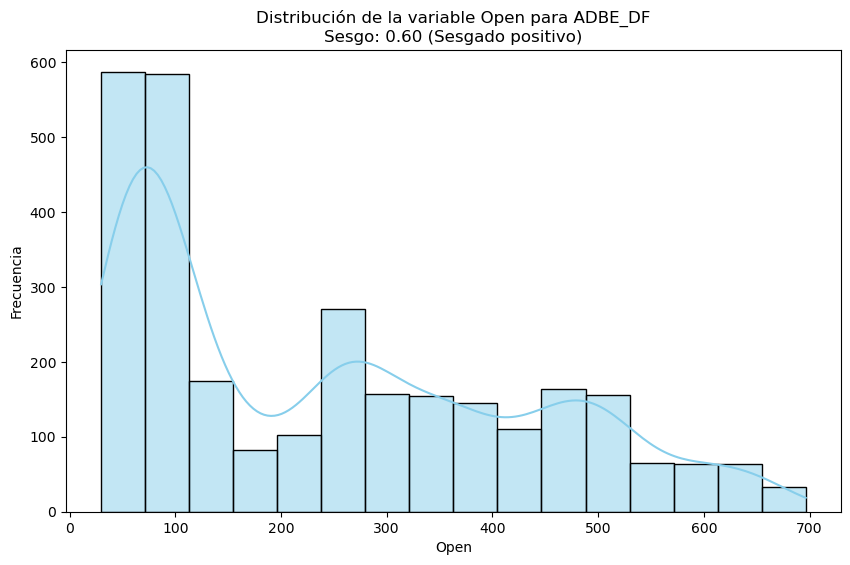

In [11]:
import seaborn as sns
from scipy.stats import skew

for df in stocks_dict.keys():
  if df in stocks:

    sesgo = skew(stocks_dict[df]['Open'])

    if abs(sesgo) > 0.5:
        tipo_sesgo = "Sesgado positivo"
    elif abs(sesgo) < -0.5:
      tipo_sesgo = "Sesgado negativo"
    else:
        tipo_sesgo = "No sesgado"

    plt.figure(figsize=(10, 6))
    sns.histplot(stocks_dict[df]['Open'], kde=True, color='skyblue')
    plt.title(f'Distribución de la variable Open para {df}\nSesgo: {sesgo:.2f} ({tipo_sesgo})')
    plt.xlabel('Open')
    plt.ylabel('Frecuencia')
    plt.show()



Analizando los resultados, observamos que la mayoría de las variables presentan un sesgo positivo, mientras que una minoría no muestra sesgo alguno.

Por el momento no estaremos realizando transformaciones no lineales a los datos, mas bien buscaremos primero implementar modelos que no usen este requisito, aunque no se descarta que en un futuro se regrese a explorar esta posibilidad para mejorar los modelos

**Análisis de las variables dependientes e independientes.**

A continuación se hará un análisis de correlación sobre las variables identificadas:

In [12]:
# Para cada dataframe, asignamos como índice la columna de la fecha
for df in stocks_dict.keys():
    if df in stocks:
        stocks_dict[df].set_index('Date', inplace= True)
        stocks_dict[df].columns = [f'{df}_{col}' for col in stocks_dict[df].columns]
    
stocks_dict['AAPL_DF']

,AAPL_DF_Open,AAPL_DF_Close,AAPL_DF_Volume
Date,,,
2012-06-01,20.327143,20.035357,520987600
2012-06-04,20.053572,20.153214,556995600
2012-06-05,20.045357,20.101070,388214400
2012-06-06,20.277500,20.409286,401455600
2012-06-07,20.617500,20.418571,379766800
...,...,...,...
2023-12-22,195.179993,193.600006,37122800
2023-12-26,193.610001,193.050003,28919300
2023-12-27,192.490005,193.149994,48087700


In [13]:
# Unimos los dataframes con la fecha como índice
first_key = next(iter(stocks_dict))
first_key

for df in stocks_dict.keys():
    if df == first_key:
        merged_stocks = stocks_dict[df]
    else:
        merged_stocks = pd.merge(merged_stocks, stocks_dict[df], how='inner', on= 'Date')

merged_stocks.set_index('Date', inplace= True)
merged_stocks

,FEDFUNDS,UNRATE,^NDX_DF_Open,^NDX_DF_Close,^NDX_DF_Volume,AAPL_DF_Open,AAPL_DF_Close,AAPL_DF_Volume,MSFT_DF_Open,MSFT_DF_Close,...,TSLA_DF_Volume,GOOG_DF_Open,GOOG_DF_Close,GOOG_DF_Volume,GOOGL_DF_Open,GOOGL_DF_Close,GOOGL_DF_Volume,ADBE_DF_Open,ADBE_DF_Close,ADBE_DF_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-01,0.16,8.2,2510.820068,2458.830078,1966370000,20.327143,20.035357,520987600,28.760000,28.450001,...,13287000,14.241370,14.221195,122774470,14.309059,14.288789,122193684,30.370001,29.820000,4362000
2012-08-01,0.13,8.1,2660.489990,2635.129883,1722530000,21.996786,21.671785,384501600,29.590000,29.410000,...,23884500,15.873004,15.757935,74060561,15.948448,15.832833,73710216,31.049999,30.690001,2738800
2012-10-01,0.16,7.8,2811.449951,2794.280029,1758170000,23.969999,23.549643,543594800,29.809999,29.490000,...,13266000,18.905388,18.973383,127194978,18.995245,19.063564,126593280,32.580002,32.619999,5201900
2012-11-01,0.16,7.7,2661.050049,2687.520020,1880140000,21.365000,21.305000,361298000,28.840000,29.520000,...,15361500,16.924065,17.125559,82311371,17.004505,17.206957,81921996,34.080002,34.360001,3681700
2013-02-01,0.15,7.7,2751.189941,2763.959961,2012930000,16.396786,16.200714,539484400,27.670000,27.930000,...,16509000,18.884216,19.317593,150405652,18.973974,19.409409,149694156,38.200001,38.340000,2416100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,5.08,3.6,14269.089844,14441.509766,4610310000,177.699997,180.089996,68901800,325.929993,332.579987,...,148029900,123.500000,124.370003,25017700,122.820000,123.720001,30772700,412.290009,426.750000,4443100
2023-08-01,5.33,3.8,15696.980469,15718.009766,4633770000,196.240005,195.610001,35175100,335.190002,336.339996,...,83166000,130.854996,131.889999,22154300,130.779999,131.550003,23166800,545.780029,549.099976,2274000
2023-09-01,5.33,3.8,15600.950195,15490.860352,4033960000,189.490005,189.460007,45732600,331.309998,328.660004,...,132272500,138.429993,136.800003,16665700,137.460007,135.660004,21524600,564.799988,563.210022,2232300


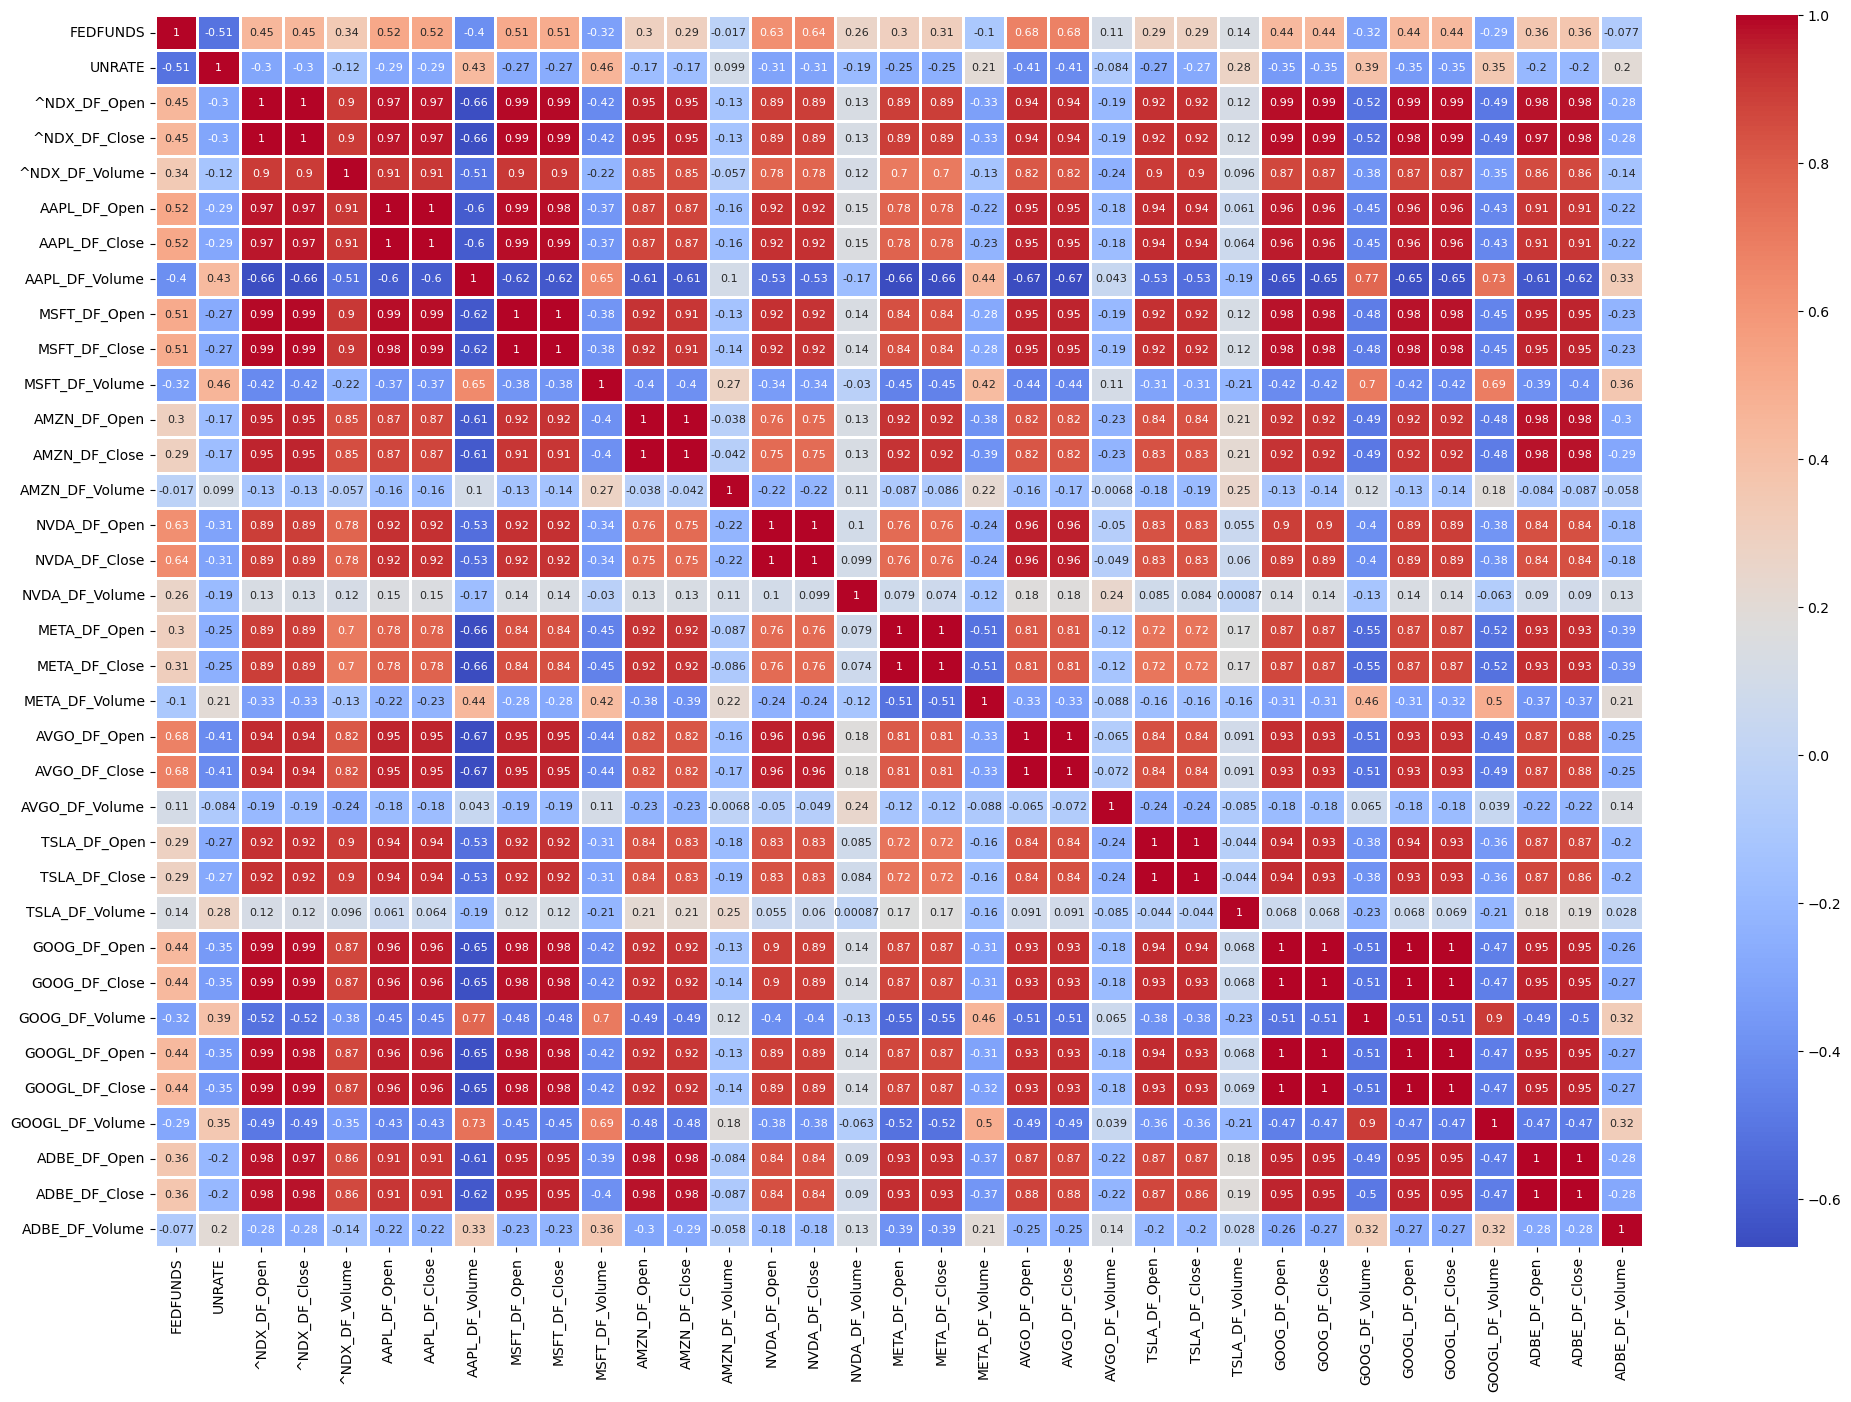

In [14]:
#Calculamos la correlación entre las variables
plt.figure(figsize=(24,16)) 
sns.heatmap(merged_stocks.corr(), cmap='coolwarm', linewidths = 1, annot=True, annot_kws={"fontsize":8})
plt.show()

Como resultado del análisis se puede observar que las variables de volumen de operación son las que tienen menos correlación contra todas las demas, seguidas de las variables macroeconómicas de la tasa de interés y tasa de desempleo. Finalmente en rojo se aprecian que en general los precios de apertura y cierre de una misma acción tienen una alta correlación mientras también una correlación (un poco más debil) contra precios de otras acciones.

**Distribución de los datos por categorías.**

Al no disponer de variables categóricas, no es posible identificar distribuciones en los datos de manera convencional.

**Patrones o agrupaciones (clusters) de datos.**

La tendencia de los datos utilizados sugiere que no existen patrones o agrupaciones discernibles en este conjunto.

**Normalización de imágenes.**

Para este proyecto no es necesario el uso de imágenes.

**¿Hay desequilibrio en las clases de la variable objetivo?**

Por el momento no se ha definido formalmente una variable objetivo, se pretende realizar la predicción del ^NDX_DF_Open, que representa el precio de apertura del índice bursatil, en el presente análisis todavía se presenta como un valor numérico. Sin embargo en futuras entregas se pretende evaluar si es más conveniente convertirlo en una variable categórica que represente si al día t+1 aumentó o disminuyó su valor respecto al cierre del día t. Esto considerando el objetivo de tener una estrategia de inversión que nos permite identificar qué es más conveniente, si mantener el ETF o venderlo a final de día.